In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
from hpa_src.config import get_data_dir, name_label_dict
from hpa_src.data.datasets import readimg, HpaDataset, TestDataset, train_val_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline 

In [3]:
DATA = get_data_dir()

In [4]:
image_df = pd.read_csv(DATA + "raw/png/train.csv")

In [5]:
test = readimg(image_df.Id[3])

In [6]:
image_df['target_list'] = image_df['Target'].map(lambda x: [int(a) for a in x.split(' ')])
image_df.head()

,Id,Target,target_list
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0,"[16, 0]"
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0,"[7, 1, 2, 0]"
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5,[5]
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1,[1]
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18,[18]


# Build Model

In [7]:
from torch.utils.data import DataLoader, random_split
from PIL import Image
from torchvision import transforms
from hpa_src.data.transforms import ToPIL
from hpa_src.models.loss import CrossEntropyLossOneHot
import torch
import torch.nn as nn

import torch.optim as optim
from torch.optim import lr_scheduler

In [8]:
input_size = 299
train_transform = transforms.Compose([
    ToPIL(),
    #transforms.Resize(input_size),
    transforms.RandomResizedCrop(input_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize((0.1149, 0.0922, 0.0553),
                         (0.1694, 0.1381, 0.1551))
])
val_transform = transforms.Compose([
    ToPIL(),
    transforms.Resize(input_size),
    transforms.ToTensor(),
    transforms.Normalize((0.1149, 0.0922, 0.0553),
                         (0.1694, 0.1381, 0.1551))
])

In [9]:
train_sampler, val_sampler = train_val_split(image_df.shape[0])
# train_sampler, val_sampler = train_val_split(100)

In [10]:
train_dataset = HpaDataset(DATA + 'raw/png/train.csv', transform=train_transform)
val_dataset = HpaDataset(DATA + 'raw/png/train.csv', transform=val_transform)

In [11]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=16, sampler=train_sampler,
    num_workers=16
)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=16, sampler=val_sampler,
    num_workers=16
)

dataloaders = {'train': train_loader, 'val': val_loader}

## Model

In [12]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [13]:
import pretrainedmodels
pretrained = pretrainedmodels.__dict__['inceptionresnetv2'](num_classes=1000, pretrained='imagenet')

In [14]:
from torch import nn
class TransferedModel(nn.Module):
    
    def __init__(self,
                 pretrained,
                 num_classes):
        super(TransferedModel, self).__init__()
        self.pretrained = pretrained
        n_feature = pretrained.last_linear.in_features
        self.classifier = nn.Sequential(
            nn.Linear(n_feature, n_feature),
            nn.BatchNorm1d(n_feature),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(n_feature, num_classes))
        self.pretrained.last_linear = self.classifier
    
    def forward(self, x):
        x = self.pretrained(x)
        return x
        
#             nn.Conv2d(n_feature, n_feature, 1),
#             nn.ReLU(inplace=True),

In [15]:
model = TransferedModel(pretrained, 28)

In [16]:
# pretrained = nn.DataParallel(pretrained, device_ids=[1])
# pretrained = pretrained.to(device)

In [17]:
criterion = CrossEntropyLossOneHot()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(pretrained.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/opt/modules/i12g/anaconda/3-5.0.1/envs/hpaic/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))


In [18]:
dataset_sizes = {'train': len(train_sampler.indices), 'val': len(val_sampler)}

In [19]:
# tmp = next(iter(dataloaders['train']))
# pretrained(tmp[0].to_device())

In [20]:
from hpa_src.models.training import ModelTrainer
from hpa_src.models.callbacks import TorchModelCheckpoint

Using TensorFlow backend.


In [21]:
trainer = ModelTrainer(model)

In [22]:
trainer.compile(optimizer_ft, criterion, device='cuda:1')

In [23]:
checker = TorchModelCheckpoint('../models/torch_trained')

## First train classifier layer

In [24]:
for p in model.parameters():
    p.requires_grad = False
for p in model.classifier.parameters():
    p.requires_grad = True

In [ ]:
trainer.fit(dataloaders['train'], dataloaders['val'], epochs=3)

/opt/modules/i12g/anaconda/3-5.0.1/envs/hpaic/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/opt/modules/i12g/anaconda/3-5.0.1/envs/hpaic/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent cal

In [ ]:
for p in model.parameters():
    p.requires_grad = True

In [ ]:
trainer.fit(dataloaders['train'], dataloaders['val'], epochs=50, model_checker = checker)

# ignite

In [ ]:
#best_model = train_model(pretrained, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)

In [ ]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import CategoricalAccuracy, Loss
from ignite.handlers import EarlyStopping

In [ ]:
from hpa_src.models.metrics import F1Score

In [ ]:
trainer = create_supervised_trainer(pretrained, optimizer_ft, criterion, device=device)

In [ ]:
def score_function(engine):
    val_loss = engine.state.metrics['loss']
    return -val_loss

In [ ]:
f1score = F1Score()
handler = EarlyStopping(patience=5, score_function=score_function, trainer=trainer)

In [ ]:
evaluator = create_supervised_evaluator(pretrained,
                                        metrics={
                                            'loss': Loss(criterion),
                                            'f1': F1Score()
                                        }, device=device)

In [ ]:
evaluator.add_event_handler(Events.COMPLETED, handler)

In [ ]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    evaluator.run(train_loader)
    metrics = evaluator.state.metrics
    print("Training Results - Epoch: {}  Avg loss: {:.2f} Avg f1: {:.2f}"
          .format(trainer.state.epoch, metrics['loss'], metrics['f1']))

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    print("Validation Results - Epoch: {}  Avg loss: {:.2f} Avg f1: {:.2f}"
          .format(trainer.state.epoch, metrics['loss'], metrics['f1']))

In [ ]:
trainer.run(train_loader, max_epochs=100)

In [ ]:
torch.save(pretrained.state_dict(), DATA + '../models/torch_3epoch')

In [85]:
evaluator.state.metrics

{'loss': 2.5641331955440414, 'f1': 0.24967516695377992}

## Cross validate threshold

In [ ]:
with torch.no_grad():
    val_preds = []
    val_true = []
    for inputs, labels in val_loader:
        inputs.to(device)
        val_preds.append(pretrained(inputs))
        val_true.append(labels)

In [50]:
val_preds = torch.cat(val_preds)

In [52]:
val_true = torch.cat(val_true)

In [71]:
scores = []
for p in np.arange(0.1,0.9,0.02):
    tmp = preds2onehot(val_preds, threshold=np.log(p/(1-p)))
    scores.append(f1_score(val_true, tmp, average='macro'))

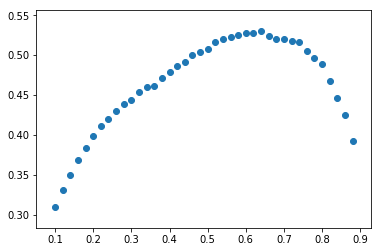

In [72]:
plt.scatter(np.arange(0.1,0.9,0.02), scores)
plt.show()

In [74]:
np.arange(0.1,0.9,0.02)[np.argmax(scores)]

0.6400000000000001

## Test prediction

In [86]:
test = TestDataset(DATA + 'raw/sample_submission.csv', transform=train_transform)

In [87]:
test_dl = DataLoader(test, batch_size=16, num_workers=8)

In [ ]:
with torch.no_grad():
    prediction = [pretrained(img) for img in test_dl]
    prediction = torch.cat(prediction)
#     prediction = preds2label(prediction)

In [89]:
# p = np.arange(0.1,0.9,0.02)[np.argmax(scores)]
p = 0.5
preds = preds2label(prediction, threshold=np.log(p/(1-p)))

In [90]:
preds = list(array2str(preds))

In [91]:
tst = pd.read_csv(DATA + "raw/sample_submission.csv")

In [92]:
tst.Predicted = preds

In [93]:
tst.to_csv(DATA + "processed/Submission.csv", index=False)

In [94]:
tst.head()

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,2
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,0 5
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0 5 25
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0 25
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,25
